In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import gymnasium as gym
from stable_baselines3 import PPO
import environment 

In [3]:
# Electricity rates
def func_price(i):
    # $/kWh
    hour = (i//6)%24
    if hour<7:
        return 0.082
    elif (hour>=7)&(hour<11):
        return 0.113
    elif (hour>=11)&(hour<17):
        return 0.17
    elif (hour>=17)&(hour<19):
        return 0.113
    else:
        return 0.082

# HVAC COP
def func_COP(To):
    return -2/25 * To + 6

In [4]:
# import data
with open('HW2_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
To = Data['To'][:6*24*2] # outdoor air temperature in degC
q_solar = Data['q_solar'][:6*24*2] # absorbed solar radiation in W
u_dist = np.hstack((q_solar[:,None], To[:,None]))

# get price and COP
Price = np.array([func_price(i) for i in range(q_solar.shape[0])])
Price = np.hstack((Price,Price))
COP = np.array([func_COP(i) for i in To])
COP = np.hstack((COP,COP))

# import building model
with open('HW2_SS-Model.pickle', 'rb') as f:
    ss_model = pickle.load(f)
Ad = ss_model['Ad']
Bd = ss_model['Bd']
Cd = ss_model['Cd']
Dd = ss_model['Dd']

Bd_HVAC = Bd[:,:1]
Bd_dist = Bd[:,1:]
Dd_HVAC = Dd[:1]
Dd_dist = Dd[1:]

In [5]:
# create an environment using the building model
Environment = environment.SimpleEnv(Ad, Bd_HVAC, Bd_dist,
                                    Cd, Dd_HVAC, Dd_dist,
                                    COP, Price, u_dist)
model = PPO("MultiInputPolicy", Environment, verbose=1, learning_rate=0.00001, gamma=0.999)
model.load("trained_RL")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
vec_env = model.get_env()
obs_history=[]
act_history=[]
obs = vec_env.reset()
obs_history.append(obs)
for i in range(288):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    obs_history.append(obs)
    act_history.append(action)

In [7]:
temperature = []
for i in range(len(obs_history)):
    temperature.append(obs_history[i]['Tin'])
temperature = np.array(temperature).flatten()

action = np.array(act_history).flatten()

# penalty=[]
# for temp in temperature:
#     if temp > 24.:
#         penalty.append(temp - 24.)
#     else:
#         penalty.append(-0.05)
# penalty = np.array(penalty)

# cost = (action/COP/6 * Price + 0.000798)*1000
# reward = cost - 10*penalty[1:]

(19.0, 31.0)

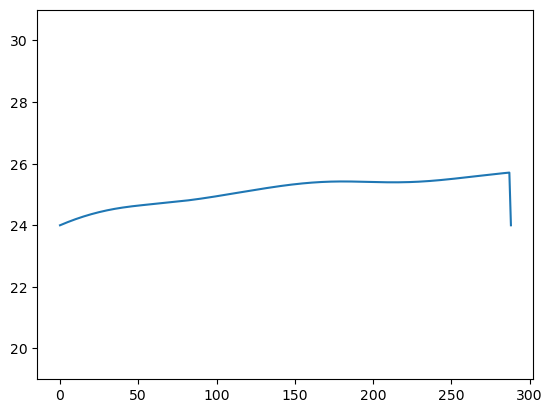

In [8]:
plt.plot(temperature)
plt.ylim(19,31)